# 卒業研究17：様々な学習データを突っ込む
元データEuF3_data.csvに対して，倍率変更と定数追加を組み合わせて学習データを多く作りロジスティック回帰とニューラルネットワークで学習してみる．テストデータは実際の実験データ．

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# データの読み込み
import os
# カレントディレクトリを取得
data_path = os.getcwd()

data = pd.read_csv(data_path + '/drive/MyDrive/卒研/EuF3_data.csv' , sep='\t')

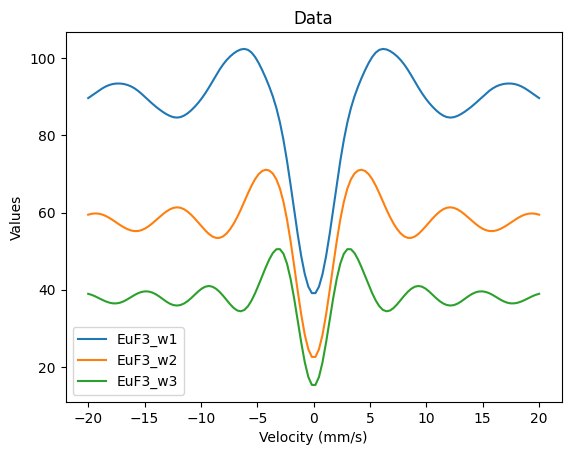

In [3]:
# 横軸に1列目のデータを使用
x = data.iloc[:, 0]

# 3列目から5列目のデータをそれぞれプロット
for i in range(2, 5):
    plt.plot(x, data.iloc[:, i], label=f'EuF3_w{i-1}')

# 凡例を追加
plt.legend()

# グラフのタイトルと軸ラベルを設定
plt.title('Data')
plt.xlabel('Velocity (mm/s)')
plt.ylabel('Values')

# グラフを表示
plt.show()

In [ ]:
from sklearn.impute import SimpleImputer
# AbExist.csvとNoAb.csvを読み込む
abexist_data = pd.read_csv(data_path + '/drive/MyDrive/卒研/AbExist.csv', delimiter=r'\t')
noab_data = pd.read_csv(data_path + '/drive/MyDrive/卒研/NoAb.csv', delimiter=r'\t')

# 列名を修正
abexist_data = abexist_data.rename(columns={'"S8SVel02Scaled': 'S8SVel02Scaled', 'S8SRuma030"': 'S8SRuma030'})

# 余分なダブルクォーテーションを取り除く
abexist_data["S8SVel02Scaled"] = abexist_data["S8SVel02Scaled"].str.replace('"', '').astype(float)
abexist_data["S8SRuma030"] = abexist_data["S8SRuma030"].str.replace('"', '').astype(int)

# 列名を修正
noab_data = noab_data.rename(columns={'"S8SV02Scaled': 'S8SV02Scaled', 'S8SEr005"': 'S8SEr005'})

# NoAb.csvのカラム名の修正
noab_data = noab_data.rename(columns={'"S8SV02Scaled': 'S8SV02Scaled', 'S8SEr005"': 'S8SEr005'})
noab_data["S8SV02Scaled"] = noab_data["S8SV02Scaled"].str.replace('"', '').astype(float)
noab_data["S8SEr005"] = noab_data["S8SEr005"].str.replace('"', '').astype(int)

# 2つのデータフレームを結合
experiment = pd.concat([abexist_data, noab_data], axis=1)

# 各カラムの値を、そのカラムの1行目の値で割る
for col in experiment.columns:
    experiment[col] = experiment[col] / experiment[col].iloc[0]

# S8SVel02Scaled から S8SRuma030 までのカラムを持つデータフレーム
data_abexist = experiment[['S8SVel02Scaled', 'S8SRuma003', 'S8SRuma006',  'S8SRuma009',
                     'S8SRuma012', 'S8SRuma015', 'S8SRuma018', 'S8SRuma021',
                        'S8SRuma024', 'S8SRuma027', 'S8SRuma030']]

# S8SV02Scaled から S8SEr005 までのカラムを持つデータフレーム
data_noab = experiment[['S8SV02Scaled','S8SEr003', 'S8SEr004', 'S8SEr005']]

data_abexist["S8SVel02Scaled"] = data_abexist["S8SVel02Scaled"] * -1
data_noab["S8SV02Scaled"] = data_noab["S8SV02Scaled"] * -1

# 組み合わせる
testdata = pd.concat([data_abexist, data_noab], axis=1)
testdata.drop('S8SVel02Scaled', axis=1, inplace=True)
testdata.drop('S8SV02Scaled', axis=1, inplace=True)

# 欠損値保管
# Creating an imputer object that replaces NaN values with the mean of the column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Applying the imputer only to the 'S8SEr003' column
testdata['S8SEr003'] = imputer.fit_transform(testdata[['S8SEr003']])

## 学習用データフレーム作成とロジスティック回帰

In [5]:
# 初期化
train_data = pd.DataFrame()

# 最初のカラム（速度）をそのままコピー
train_data[data.columns[0]] = data.iloc[:, 0]
# 要素定義
sum_factor = [0,50,100,150,200,250,300]
product_factor = [0.5,1,2,5,10]

In [ ]:
pre_data = data.copy()
for i in range(len(sum_factor)):
  # 元データ和算
  for column in data.columns[2:]:
    for j in range(len(product_factor)):
      new_column = f"{column}_{i}_{j}"  # 文字列として連結
      train_data[new_column] = (pre_data[column] + sum_factor[i]) * product_factor[j]

In [ ]:
train_data.head()

In [8]:
number = 10
random_number = 10

In [ ]:
# ノイズ付加
error_data = pd.DataFrame()
error_data[data.columns[0]] = data.iloc[:, 0]

for column in train_data.columns[1:]:
  true = train_data[column]
  for i in range(number):
    error = []
    for j in range(len(true)):
      rng = np.random.default_rng()
      np.random.seed(j + rng.integers(100))
      error.append(true.iloc[j] + np.random.normal(0, np.sqrt(true.iloc[j])))

    error_data[column +  str(i)] = error

# 非教師データの作成
for column in train_data.columns[1:]:
  true = train_data[column]
  for i in range(random_number):
    error = []
    for j in range(len(true)):
      rng = np.random.default_rng()
      np.random.seed(j + rng.integers(100))
      error.append(np.random.normal(true.iloc[j], np.sqrt(true.iloc[j])))

    error_data[column +  str(i) + "error"] = error

# 正解ラベル
y = [1]*(len(sum_factor)*len(product_factor)*3*number) + [0]*(len(sum_factor)*len(product_factor)*3*random_number)

In [10]:
error_data.head()

,Velocity (mm/s),EuF3_w1T7_8S5_85_0_00,EuF3_w1T7_8S5_85_0_01,EuF3_w1T7_8S5_85_0_02,EuF3_w1T7_8S5_85_0_03,EuF3_w1T7_8S5_85_0_04,EuF3_w1T7_8S5_85_0_05,EuF3_w1T7_8S5_85_0_06,EuF3_w1T7_8S5_85_0_07,EuF3_w1T7_8S5_85_0_08,...,EuF3_w3T7_8S5_85_6_40error,EuF3_w3T7_8S5_85_6_41error,EuF3_w3T7_8S5_85_6_42error,EuF3_w3T7_8S5_85_6_43error,EuF3_w3T7_8S5_85_6_44error,EuF3_w3T7_8S5_85_6_45error,EuF3_w3T7_8S5_85_6_46error,EuF3_w3T7_8S5_85_6_47error,EuF3_w3T7_8S5_85_6_48error,EuF3_w3T7_8S5_85_6_49error
0,-20.000000,46.691846,50.540482,56.556918,44.759322,56.819241,52.398901,46.026122,40.393509,42.754028,...,3354.531149,3414.932289,3487.662964,3354.531149,3335.582300,3264.719848,3372.332960,3466.628293,3350.572193,3471.658388
1,-19.685039,45.771899,41.076251,45.628379,56.915413,22.872920,52.742718,38.481752,48.649900,52.553218,...,3436.046627,3331.561101,3325.818374,3435.444494,3450.555838,3414.091233,3367.968502,3366.220303,3367.968502,3414.048679
2,-19.370079,54.156770,42.670558,47.634583,47.997631,47.997631,33.685178,51.155839,46.207067,46.976724,...,3412.832856,3280.853110,3347.367810,3540.051174,3347.284834,3303.527782,3291.869448,3341.187136,3386.682355,3272.712342
3,-19.055118,52.005214,47.550997,54.821333,46.346446,43.698635,43.694948,49.015080,33.956426,48.795183,...,3390.914800,3442.021884,3317.440212,3279.628270,3416.835956,3482.027003,3357.791681,3393.030216,3374.904344,3535.395099
4,-18.740157,44.268294,64.486463,42.057594,55.132062,43.176548,45.139837,39.693319,46.580757,39.693319,...,3403.638112,3406.968346,3276.511581,3407.436645,3422.795558,3450.668851,3450.806756,3360.427618,3450.668851,3357.742760


In [11]:
len(y)

2100

### ロジスティック回帰

In [12]:
# 入力データとして、各カラムを1つのサンプルとする
X_train = error_data.drop('Velocity (mm/s)', axis=1)
X_train = X_train.T
y_train = y

X_test = testdata.T
y_test = [1]*10 + [0]*3

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       1.00      0.70      0.82        10

    accuracy                           0.77        13
   macro avg       0.75      0.85      0.75        13
weighted avg       0.88      0.77      0.79        13



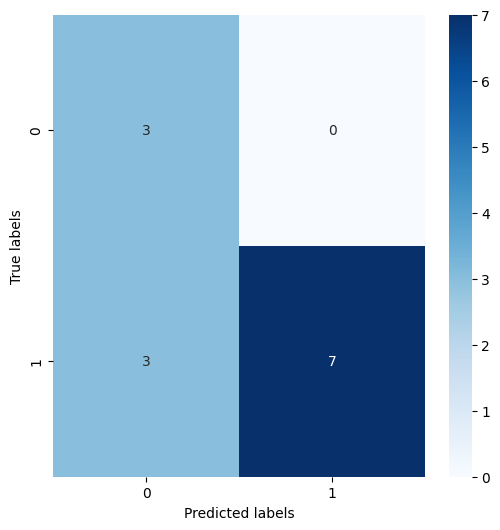

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# ロジスティック回帰モデルを訓練
clf = LogisticRegression(max_iter=10000)
clf.fit(X_train, y_train)

# テストデータを使って予測
y_pred = clf.predict(X_test)

# 評価
print(classification_report(y_test, y_pred))

# 混同行列の可視化
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()